### Imports 👽

In [319]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('../..', 'src')))
from data_classes.enums import Scenario, SamplingMethod
from data_classes.scenario import ScenarioSettings

### Prepare Data to Compare ⚙️

In [320]:
scenario = Scenario.PROJECTILE

output_dir = os.path.abspath(os.path.join('../..', 'data', scenario.value, 'output'))

sampling_types = [SamplingMethod.SOBOL]
epochs_types = [100, 500, 1000, 1500, 2000]

dfs = []
for sampling_type in sampling_types:
    for epochs in epochs_types:
        df = pd.read_csv(os.path.join(output_dir, f'{sampling_type.value}_{epochs}epochs_results.csv'))
        df['epochs'] = epochs
        df['sampling_type'] = sampling_type.value
        dfs.append(df)

together_df = pd.concat(dfs, ignore_index=True)
together_df.to_csv(os.path.join(output_dir, 'together.csv'), index=False)

# Filter
depths = [4,8,16] # [4,8,16]
epochs = [1000,1500,2000] # [100,500,1000,1500,2000]
widths = [6,12,24] # [6,12,24]
learning_rates = [0.01] # [0.01,0.001]
lambdas = [1.0e-04,1.0e-05,1.0e-06,1e-07] # [1.0e-04,1.0e-05,1.0e-06,1e-07]
# training_set_sizes = [4096, 8192] # Sum Sines [128, 256, 512, 1024, 2048, 4096, 8192]
training_set_sizes = [16, 32, 64, 128, 256, 512, 1024] # Projectile [16, 32, 64, 128, 256, 512, 1024]
# print(ScenarioSettings(scenario).TRAINING_SET_SIZES)
together_df = together_df[
    together_df['epochs'].isin(epochs) &
    together_df['num_hidden_layers'].isin(widths) &
    together_df['depth'].isin(depths) &
    together_df['learning_rate'].isin(learning_rates) &
    together_df['train_size'].isin(training_set_sizes)
]

### Analysis 📊

#### Distribution of training_set_sizes among the best NNs

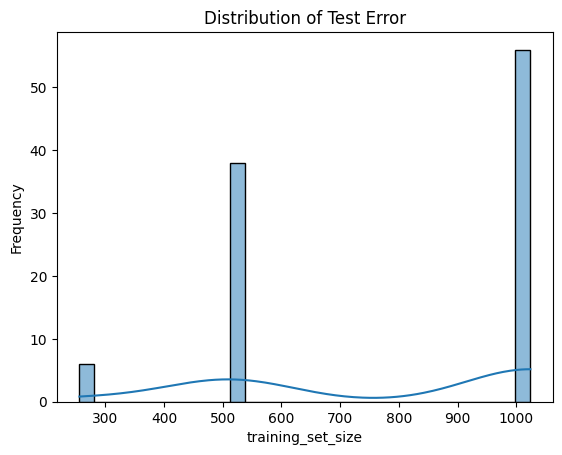

In [321]:
# test_error_limit = .02
# good_nns_df = together_df[together_df['test_error'] <= test_error_limit]
# bad_nns_df = together_df[together_df['test_error'] > test_error_limit]

good_nns_df = together_df.nsmallest(100, 'test_error')
bad_nns_df = together_df.drop(good_nns_df.index)

sns.histplot(good_nns_df['train_size'], kde=True, bins=30)
plt.title('Distribution of Test Error')
plt.xlabel('training_set_size')
plt.ylabel('Frequency')
plt.show()

In [322]:
print('Number of Good NNs: ', len(good_nns_df))
print('Number of Bad NNs : ', len(bad_nns_df))

Number of Good NNs:  100
Number of Bad NNs :  656


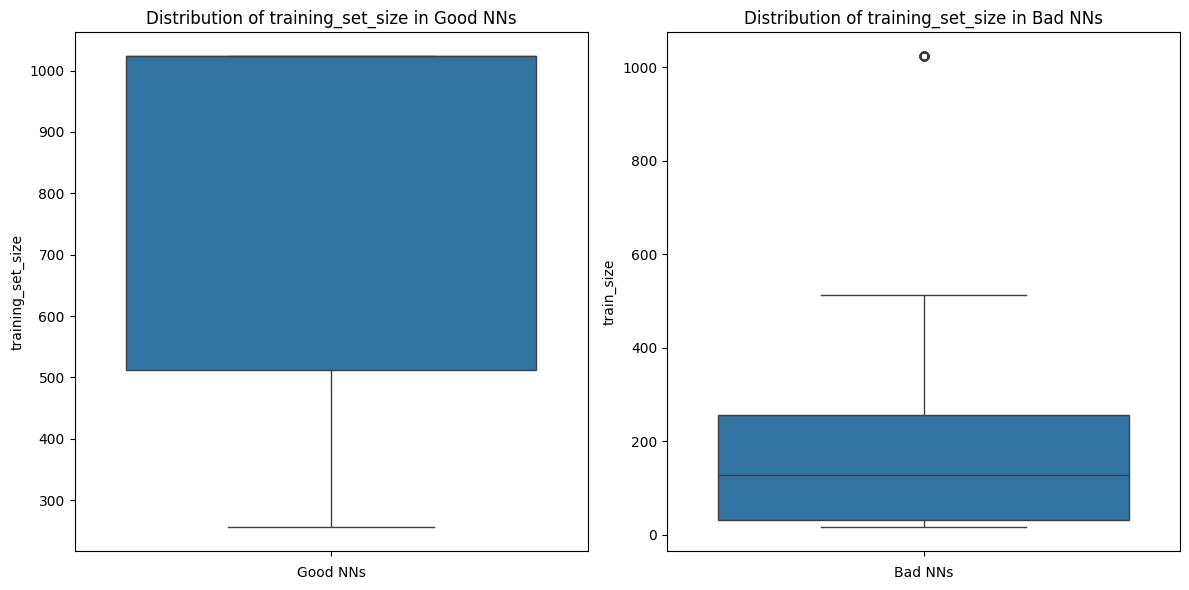

In [323]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=good_nns_df, y="train_size", ax=axes[0])
axes[0].set_title("Distribution of training_set_size in Good NNs")
axes[0].set_ylabel("training_set_size")
axes[0].set_xlabel("Good NNs")

sns.boxplot(data=bad_nns_df, y="train_size", ax=axes[1])
axes[1].set_title("Distribution of training_set_size in Bad NNs")
axes[1].set_ylabel("train_size")
axes[1].set_xlabel("Bad NNs")

plt.tight_layout()
plt.show()

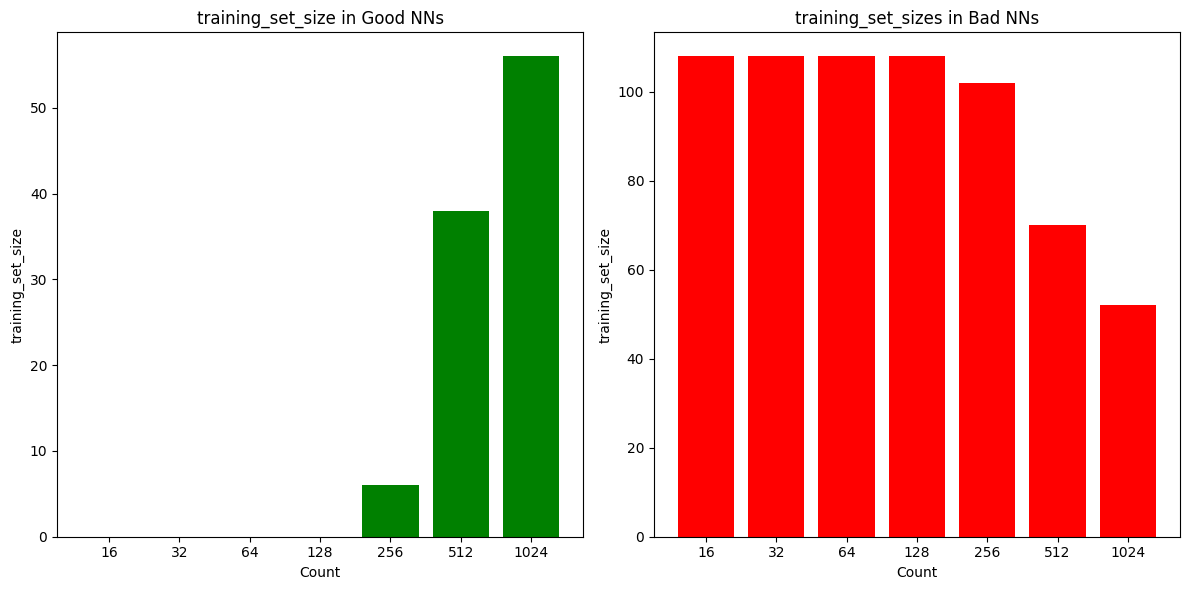

In [324]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Count occurrences of each training_set_size in good_nns
good_training_set_sizes_counts = good_nns_df['train_size'].value_counts().reindex(training_set_sizes, fill_value=0)
axes[0].bar(good_training_set_sizes_counts.index.astype(str), good_training_set_sizes_counts.values, color='green')
axes[0].set_title("training_set_size in Good NNs")
axes[0].set_ylabel("training_set_size")
axes[0].set_xlabel("Count")

# Count occurrences of each training_set_size in bad_nns
bad_training_set_size_counts = bad_nns_df['train_size'].value_counts().reindex(training_set_sizes, fill_value=0)
axes[1].bar(bad_training_set_size_counts.index.astype(str), bad_training_set_size_counts.values, color='red')
axes[1].set_title("training_set_sizes in Bad NNs")
axes[1].set_ylabel("training_set_size")
axes[1].set_xlabel("Count")

plt.tight_layout()
plt.show()

#### Difference between best candidates for training_set_size

Best Test Error for training_set_size 16: 0.9935381412506104
Best Test Error for training_set_size 32: 0.5303657054901123
Best Test Error for training_set_size 64: 0.2958678603172302
Best Test Error for training_set_size 128: 0.1710748374462127
Best Test Error for training_set_size 256: 0.0756727382540702
Best Test Error for training_set_size 512: 0.046811319887638
Best Test Error for training_set_size 1024: 0.0269210860133171


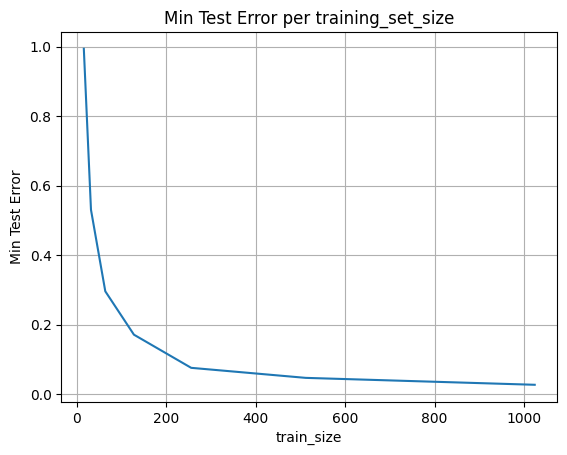

In [325]:
test_errors = []
for i in training_set_sizes:
    test_errors.append(together_df.loc[together_df['train_size']==i, 'test_error'].min())
    print(f'Best Test Error for training_set_size {i}: {test_errors[-1]}')

plt.plot(training_set_sizes, test_errors)
plt.xlabel('train_size')
plt.ylabel('Min Test Error')
plt.title('Min Test Error per training_set_size')
plt.grid(True)
plt.show()

Mean Test Error for training_set_size 16: 1.466885428737711
Mean Test Error for training_set_size 32: 1.0220294374006766
Mean Test Error for training_set_size 64: 0.7210510889137233
Mean Test Error for training_set_size 128: 0.40579942448271644
Mean Test Error for training_set_size 256: 0.2016814723610878
Mean Test Error for training_set_size 512: 0.14521973052372533
Mean Test Error for training_set_size 1024: 0.11402585664419108


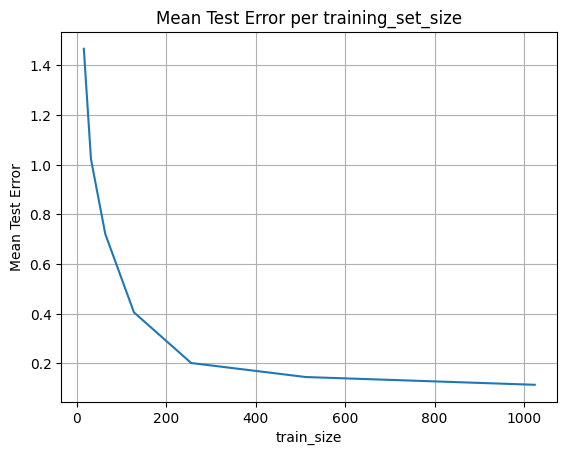

In [326]:
test_errors = []
for i in training_set_sizes:
    test_errors.append(together_df.loc[together_df['train_size']==i, 'test_error'].mean())
    print(f'Mean Test Error for training_set_size {i}: {test_errors[-1]}')

plt.plot(training_set_sizes, test_errors)
plt.xlabel('train_size')
plt.ylabel('Mean Test Error')
plt.title('Mean Test Error per training_set_size')
plt.grid(True)
plt.show()

Mean among 10 best test errors for training_set_size 16: 1.0743832111358642
Mean among 10 best test errors for training_set_size 32: 0.6568825542926788
Mean among 10 best test errors for training_set_size 64: 0.4018795251846313
Mean among 10 best test errors for training_set_size 128: 0.2168189644813537
Mean among 10 best test errors for training_set_size 256: 0.08945196196436879
Mean among 10 best test errors for training_set_size 512: 0.05415075048804278
Mean among 10 best test errors for training_set_size 1024: 0.04186656847596164


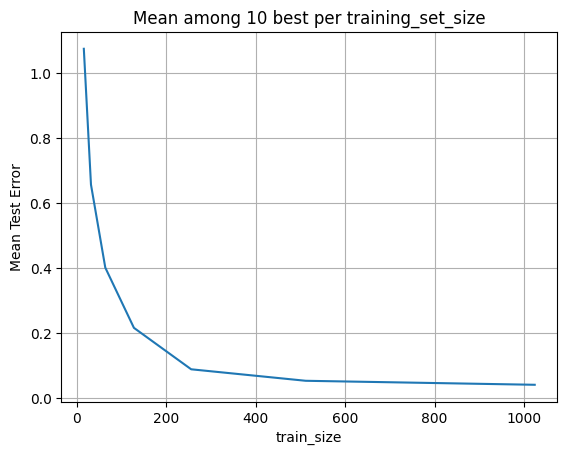

In [327]:
test_errors = []
num_best = 10
for i in training_set_sizes:
    selection_df = together_df.loc[together_df['train_size']==i].nsmallest(num_best, 'test_error')
    test_errors.append(selection_df.test_error.mean())
    print(f'Mean among {num_best} best test errors for training_set_size {i}: {test_errors[-1]}')

plt.plot(training_set_sizes, test_errors)
plt.xlabel('train_size')
plt.ylabel('Mean Test Error')
plt.title(f'Mean among {num_best} best per training_set_size')
plt.grid(True)
plt.show()